In [8]:
import numpy as np
from scipy.spatial.distance import pdist

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
import umap

from sklearn.datasets import (
    make_blobs, load_iris, load_wine, load_digits, 
    fetch_openml, load_breast_cancer
)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from lib.dice_mod import Gainer, random_opt, gradient_ascent, plot_heatmap, adam_opt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


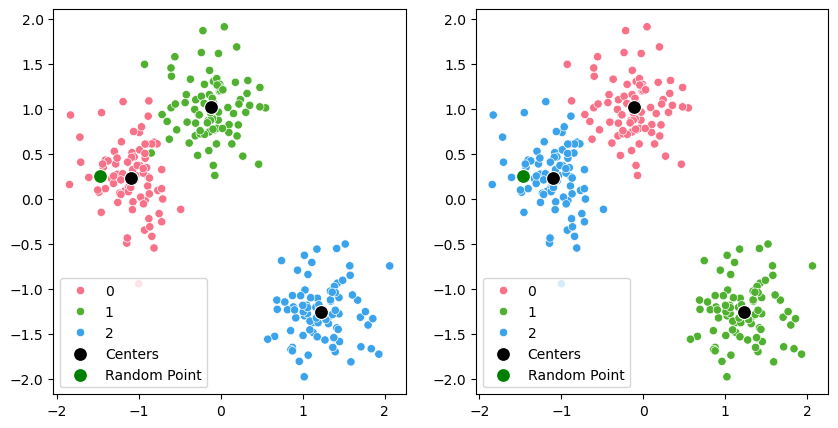

In [28]:
k = 3

X, y = make_blobs(centers=k, cluster_std=1.6, n_features=2, n_samples=250, random_state=1234)
# X, y = load_breast_cancer(return_X_y=True)
# X, y = load_iris(return_X_y=True)
X = StandardScaler().fit_transform(X)

km = KMeans(n_clusters=k)
yy = km.fit_predict(X)
C = km.cluster_centers_

# random point from X:
np.random.seed(123)
random_point = X[[np.random.randint(0, X.shape[0])]]
instance_cluster = km.predict(random_point)[0]


def plot(X, y, C, x, pca=False, use_umap=False):
    assert not (pca and use_umap)
    if use_umap or pca:
        reducer = umap.UMAP() if use_umap else PCA(n_components=2)
        X = reducer.fit_transform(X)
        C = reducer.transform(C)
        x = reducer.transform(x)

    unique_labels = np.unique(y)
    palette = sns.color_palette("husl", len(unique_labels))

    _fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    for ax, h in zip(axs, [y, yy]):
        sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=h, palette=palette, legend="full", ax=ax)
        sns.scatterplot(x=C[:, 0], y=C[:, 1], color='black', s=100, marker='o', label='Centers', ax=ax)
        sns.scatterplot(x=x[:, 0], y=x[:, 1], color='green', s=100, marker='o', label='Random Point', ax=ax)
    plt.show()

plot(X, y, C, random_point, pca=False, use_umap=False)

# Example usage

X: (250, 2)
C: (3, 2)
x: (1, 2)
iter: 594, score: 0.8059575948329599
target: 0, prediction: 0
X: (250, 2)
C: (3, 2)
x: (1, 2)
iter: 462, score: 0.5531723555149418
target: 1, prediction: 1


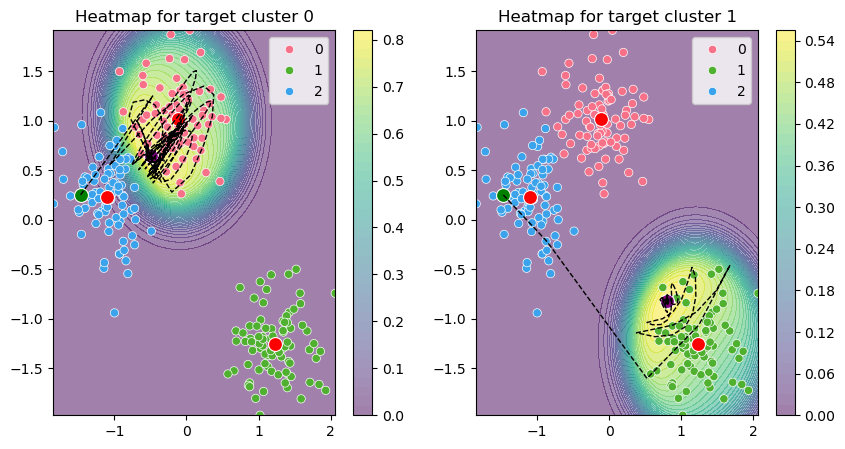

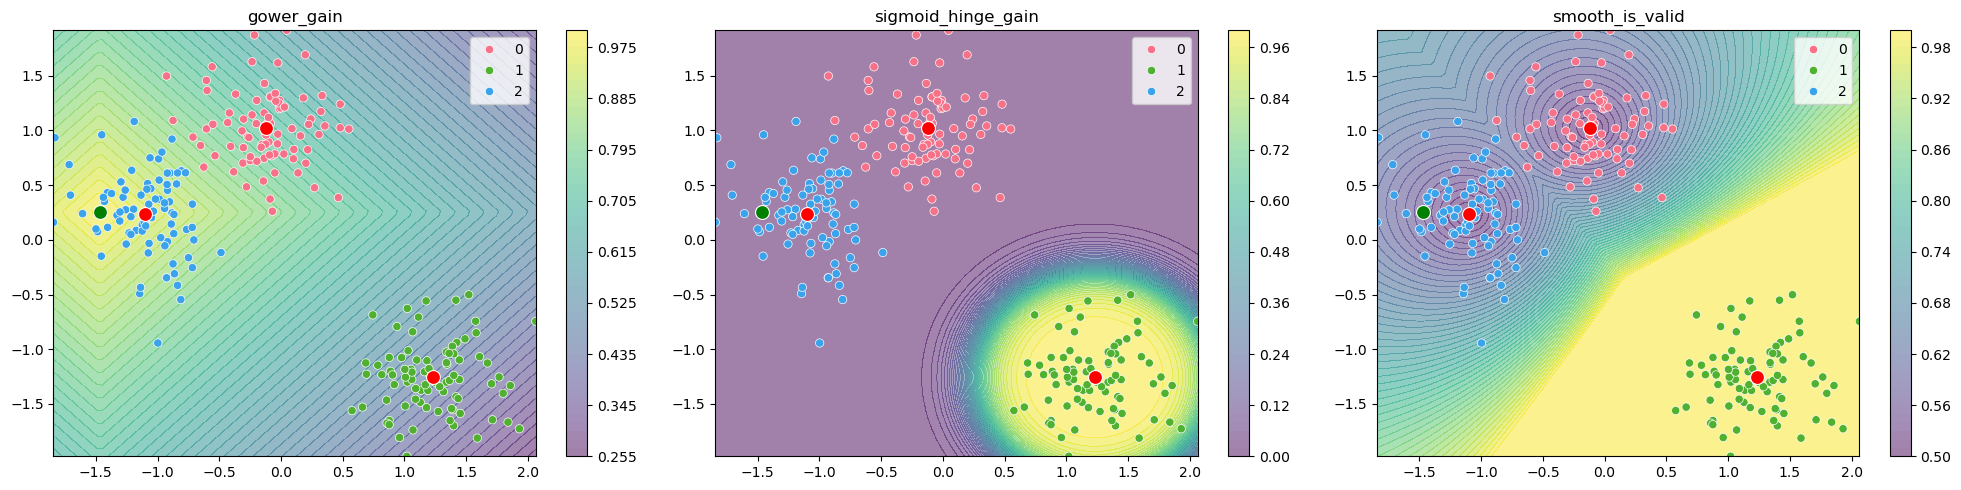

In [ ]:

targets = set(range(k))
targets.remove(instance_cluster)
fig, axs = plt.subplots(1, len(targets), figsize=(10, 5))

for i, target in enumerate(targets):
    if target == instance_cluster: continue
    l = Gainer(C, X, target, random_point, eps=0.0)
    # sol, hist = gradient_ascent(random_point, l.gain, dbg=False, lr=0.1, max_iter=1000)
    sol, hist = adam_opt(random_point, l.gain)
    # sol, hist = random_opt(random_point, l.gain)
    print(f"target: {target}, prediction: {int(km.predict(sol.reshape(1, -1))[0])}")
    plot_heatmap(
        X, yy, C, random_point, l.gain, target_cluster=target, 
        use_pca=False, 
        solutions=[sol], 
        histories=[hist],
        ax=axs[i],
    )
    axs[i].set_title(f'Heatmap for target cluster {target}')
    fig.colorbar(axs[i].collections[0], ax=axs[i])


fig, axes = plt.subplots(1, len(l.gain_weights.keys()), figsize=(20, 5))
for i, gain_fn in enumerate(l.gain_weights.keys()):
    plot_heatmap(X, yy, C, random_point, gain_fn, target_cluster=0, use_pca=False, ax=axes[i])
    axes[i].set_title(gain_fn.__name__)
    fig.colorbar(axes[i].collections[0], ax=axes[i])
fig.tight_layout()
plt.show()

# MNIST 784 Example

In [32]:
def load_mnist_clustering():
    X, target = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
    X = X.astype(np.float64)
    target = target.astype(int)
    print(f"X shape: {X.shape}")

    # mdist = np.max(pdist(X)) <----- Extremely slow! value is hardcoded below
    mdist = 4303.319300261137
    X = X / mdist
    # X = StandardScaler().fit_transform(X)

    km = KMeans(n_clusters=10, random_state=42)
    y = km.fit_predict(X)
    C = km.cluster_centers_
    return X, y, C, target, km

X, y, C, target, km = load_mnist_clustering()

X shape: (70000, 784)


real label: 3
cluster label: 3


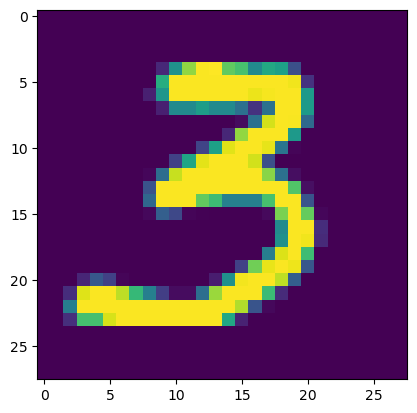

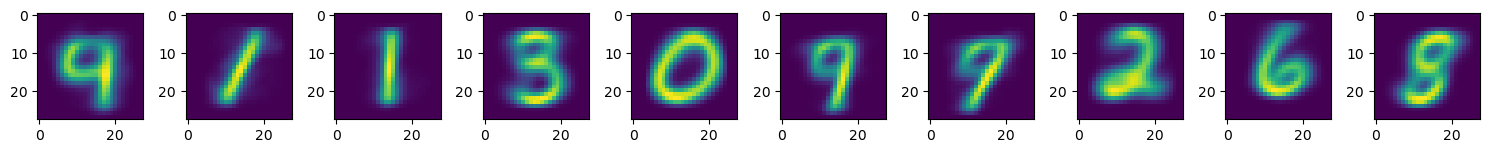

In [33]:
idx = 975
random_point = X[idx].reshape(1, -1)

def showim(x, ax = None):
    p = plt if ax is None else ax
    p.imshow(x[0].reshape(28, 28))
    if ax is None:
        plt.show()

print(f"real label: {target[idx]}")
print(f"cluster label: {y[idx]}")
showim(random_point)

fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i, c in enumerate(C):
    showim(c.reshape(1, -1), ax=axes[i])
plt.tight_layout()
plt.show()


X: (70000, 784)
C: (10, 784)
x: (1, 784)
iter: 201, score: 0.8808732883827666
iter: 201, score: 0.8650880340759822
iter: 201, score: 0.8419592404400416
iter: 201, score: 0.8184856613056998
iter: 201, score: 0.7935106027966196
iter: 201, score: 0.7656107853947527
iter: 201, score: 0.7288206658074226
iter: 199, score: 0.6076523696754483
iter: 158, score: 0.6037409052284093
iter: 291, score: 0.518224619353895
iter: 210, score: 0.394680114944512


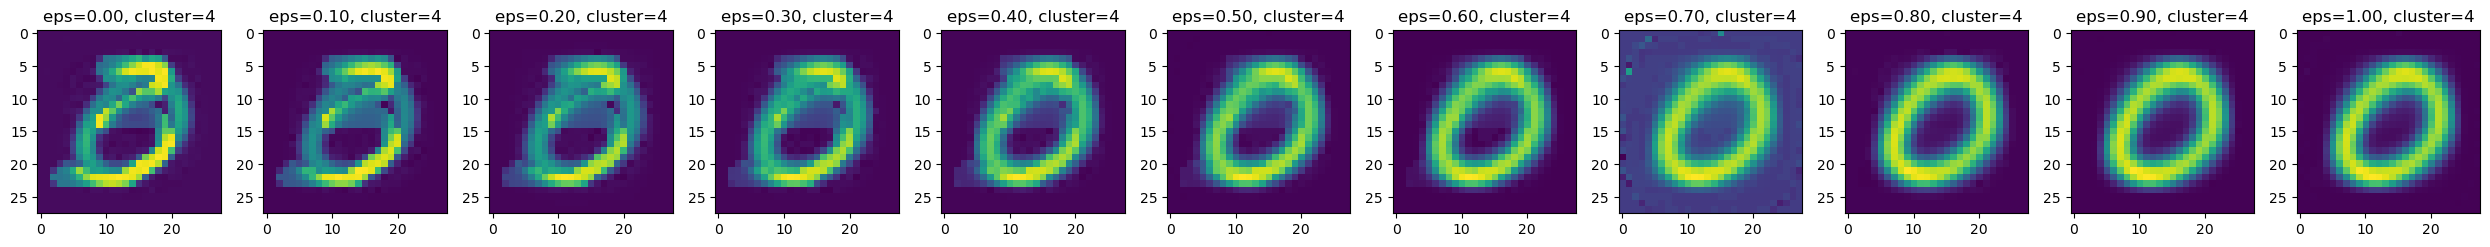

In [41]:
fig, axes = plt.subplots(1, 11, figsize=(25, 5))
l = Gainer(C, X, 4, random_point)
for i,e in enumerate(np.linspace(0,1,11)):
    l.eps = e
    sol, _hist = gradient_ascent(random_point, l.gain, dbg=False, lr=0.1)
    # sol, _hist = adam_opt(random_point, l.gain, lr=1)
    showim(sol, ax=axes[i])
    axes[i].set_title(f"eps={e:.2f}, cluster={km.predict(sol)[0]}")
plt.tight_layout()
plt.show()